# Predicting Term Sheet Purchase

#### Model Buidling Steps

- 
- 
- 
- 
- 
- 
- 

#### References

- https://stackoverflow.com/questions/46062679/right-order-of-doing-feature-selection-pca-and-normalization

- https://towardsdatascience.com/preventing-data-leakage-in-your-machine-learning-model-9ae54b3cd1fb

- https://www.mikulskibartosz.name/pca-how-to-choose-the-number-of-components/

- https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

- https://stats.stackexchange.com/questions/363548/use-of-smote-with-training-test-and-dev-sets

- https://datascience.stackexchange.com/questions/27615/should-we-apply-normalization-to-test-data-as-well

- https://ro-che.info/articles/2017-12-11-pca-explained-variance

- https://www.researchgate.net/deref/http%3A%2F%2Fwww.marcoaltini.com%2Fblog%2Fdealing-with-imbalanced-data-undersampling-oversampling-and-proper-cross-validation

> Import analysis and visualization libraires

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns 
from pandas.api.types import is_numeric_dtype

> Import dataset

- drop duration column (directly impacts the target varible and not good for modelling)

In [2]:
path= '../../datasets/main_data/bank-additional-full.csv'
full_bank = pd.read_csv(path, sep=';')

In [3]:
full_bank.shape

(41188, 21)

In [4]:
full_bank.drop('duration', axis=1, inplace=True)

In [5]:
full_bank.shape

(41188, 20)

> import from project-defined modules

In [6]:
from plot import plot_univariate, plot_bivariate
from data import check_outliers, treat_outliers, scale_data
from model import check_imbalance, plot_pca_components, encode

> Import preprocessing libraries

In [7]:
from sklearn.preprocessing import StandardScaler,RobustScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
from imblearn.over_sampling import SMOTE, _random_over_sampler
from sklearn.decomposition import PCA
from sklearn.feature_selection import f_classif, from_model, SelectKBest,chi2, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest # outlier detection and re,oval
from collections import Counter

/home/patrick/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.from_model module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


> Import estimator libraries

In [8]:
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV
import xgboost
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

> Import libraries for measuring model perofrmance

In [9]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate

> Import production libraries

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from imblearn.pipeline import Pipeline as ImbPipe
import joblib

#### Data Preprocessing

In [11]:
full_bank

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [12]:
full_bank.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

In [13]:
full_bank.isna().any()

age               False
job               False
marital           False
education         False
default           False
housing           False
loan              False
contact           False
month             False
day_of_week       False
campaign          False
pdays             False
previous          False
poutcome          False
emp.var.rate      False
cons.price.idx    False
cons.conf.idx     False
euribor3m         False
nr.employed       False
y                 False
dtype: bool

#### Outlier Detection and Treatment

> check for outliers

In [14]:
check_outliers(full_bank)

,age,campaign,pdays,previous,cons.conf.idx
0,56,1,999,0,-36.4
1,57,1,999,0,-36.4
2,37,1,999,0,-36.4
3,40,1,999,0,-36.4
4,56,1,999,0,-36.4
...,...,...,...,...,...
41183,73,1,999,0,-50.8
41184,46,1,999,0,-50.8
41185,56,2,999,0,-50.8
41186,44,1,999,0,-50.8


> treat outliers

In [15]:
# iso = IsolationForest(contamination=0.1)
# yhat = iso.fit_predict(full_bank.select_dtypes(exclude='object'))
# # select all rows that are not outliers
# mask = yhat != -1 
# clean_df1 = full_bank[mask]
# # summarize the shape of the updated training dataset
# print(clean_df1.shape)

In [16]:
clean_df1=treat_outliers(data=full_bank, type='isf')

In [17]:
clean_df1

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40543,19,student,single,high.school,no,unknown,unknown,cellular,aug,tue,1,999,0,nonexistent,-1.7,94.027,-38.3,0.886,4991.6,yes
40545,31,admin.,single,high.school,no,no,no,cellular,aug,tue,1,999,1,failure,-1.7,94.027,-38.3,0.886,4991.6,no
40549,58,retired,divorced,basic.4y,no,no,no,telephone,aug,tue,1,999,0,nonexistent,-1.7,94.027,-38.3,0.886,4991.6,no
40550,34,blue-collar,married,basic.9y,no,yes,no,cellular,aug,tue,2,999,0,nonexistent,-1.7,94.027,-38.3,0.886,4991.6,no


#### Now let's check for class imbalance

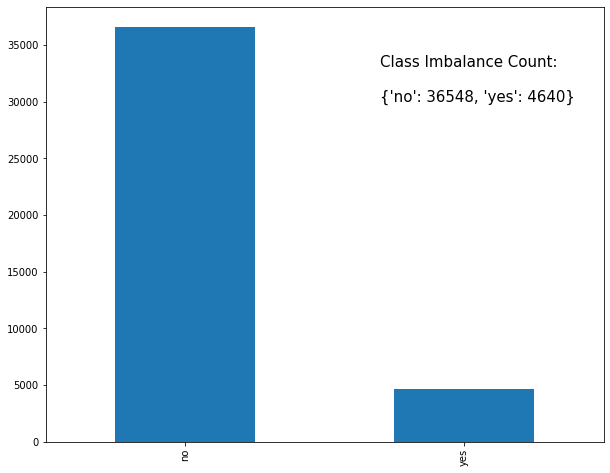

In [18]:
check_imbalance(full_bank, label='y')

> We have a very high class imbalance

> This would be dealt with after splitting out data to train and test and applied only to train to avoid data leakage

#### split data

> Beofore further preprocessing, it is important we split the data into train and test set to avoid `data leakage`

In [19]:
features, target = clean_df1.drop('y', axis=1), pd.DataFrame(clean_df1['y'])

#### encode categorical variables

In [20]:
features = encode(features)
features

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,0,...,41,42,43,44,45,46,47,48,49,50
0,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,57,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,37,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,40,1,999,0,1.1,93.994,-36.4,4.857,5191.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37062,43,1,999,0,-2.9,92.469,-33.6,1.029,5076.2,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
37063,42,1,999,0,-2.9,92.469,-33.6,1.029,5076.2,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
37064,42,1,999,0,-2.9,92.469,-33.6,1.029,5076.2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
37065,32,1,999,0,-2.9,92.469,-33.6,1.029,5076.2,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [21]:
target = encode(target)

[array(['no', 'yes'], dtype=object)]


In [22]:
target

,0,1
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
...,...,...
37064,0.0,1.0
37065,1.0,0.0
37066,1.0,0.0
37067,1.0,0.0


> make shape equal

In [23]:
target=target.iloc[0:features.shape[0]]

In [24]:
target

,0,1
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
...,...,...
36379,1.0,0.0
36380,1.0,0.0
36381,1.0,0.0
36382,1.0,0.0


> trim target varibles `purchase` to a single column of `yes`

In [25]:
target.drop(0, axis=1, inplace=True)

/home/patrick/.local/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [26]:
target

,1
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
36379,0.0
36380,0.0
36381,0.0
36382,0.0


In [27]:
X_train, X_test, y_train, y_test = train_test_split(features, target,
                                               test_size=.10, random_state=1234)

In [28]:
X_train

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,0,...,41,42,43,44,45,46,47,48,49,50
34573,28,1,999,0,-1.8,92.893,-46.2,1.266,5099.1,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
20919,34,1,999,0,1.4,93.444,-36.1,4.964,5228.1,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
36195,66,2,999,0,-1.8,92.893,-46.2,1.270,5099.1,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
19466,30,1,999,0,1.4,93.444,-36.1,4.968,5228.1,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
31095,25,1,999,0,-1.8,92.893,-46.2,1.334,5099.1,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32845,32,2,999,1,-1.8,92.893,-46.2,1.299,5099.1,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
17190,38,2,999,0,1.4,93.918,-42.7,4.962,5228.1,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
24131,42,1,999,0,-0.1,93.200,-42.0,4.191,5195.8,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
34565,28,1,999,1,-1.8,92.893,-46.2,1.266,5099.1,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


#### Deal with class imbalance

In [29]:
y_train[1].value_counts()

0.0    30437
1.0     2308
Name: 1, dtype: int64

> Since we have an imbalance case of very high majority vs very low minority,

> a good decision would be to use the SMOTE technique of oversampling the minority to mathc the majority class

> However, accroding to some research, [example](https://kiwidamien.github.io/how-to-do-cross-validation-when-upsampling-data.html), oversmapling before cross validation is a bad idea, as it leads to  high scores but overfitted model. Hence we would suspend sampling till when we are ready to apply cross validation on the train sets

> We now have a balanced class and can go on to further preprocess

#### Normalize X_train and X_test datasets

> I would be using the RobustScaler which is less prone to outliers

In [30]:
X_train_scaled = scale_data(X_train)
X_test_scaled = scale_data(X_test)

In [31]:
X_train_scaled

array([[-0.71428571, -0.5       ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.28571429, -0.5       ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 2.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.28571429, -0.5       ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.71428571, -0.5       ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.71428571, -0.5       ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [32]:
X_test_scaled

array([[-0.07142857, -0.5       ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.5       , -0.5       ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.71428571,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.35714286,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.35714286,  0.5       ,  0.        , ...,  0.        ,
         1.        , -1.        ],
       [-0.28571429,  0.5       ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [33]:
X_train_scaled.shape 

(32745, 60)

#### Dimensionality Reduction

> RIght now, our input variables are quite large, which has potential of affecting our prediciton

> To optimise the predictive features of our variables and save memory space on the model,

> we can reduce the number of features using PCA

First let's plot the number of components we need to get the most explained variance of our data

- Xtrain

In [34]:
# def plot_pca_components(data):
#     pca = PCA().fit(data)
#     plt.plot(np.cumsum(pca.explained_variance_ratio_))
#     plt.xlabel('number of components')
#     plt.ylabel('cumulative explained variance');  

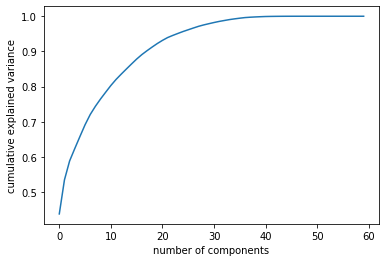

In [35]:
plot_pca_components(X_train_scaled)

From the plot above, we can see that we need about 50 components to get an high explained variance

and no longer 62 features from the scaled X train set

##### Before I move further let's test that PCA was a good decsion after all by fitting the PCA in a Logistic regression model usng stratified cross validation and comparing the score achived without using PCA

> All of this would be placed within a pipeline. 

> I would also be trying out other algrithms like XGboost and MultilayerPerceptron Netowrk (a neural network model for classification)

> Accroding to [this](https://imbalanced-learn.org/stable/generated/imblearn.pipeline.Pipeline.html) Imblearn pipeline example for working with SMOTE and PCA,

> I would be ordering my steps in the following order

1. SMOTE

2. PCA

3. ESTIMATOR

> Logistic Regression Modelling

In [36]:
X_test_scaled

array([[-0.07142857, -0.5       ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.5       , -0.5       ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.71428571,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.35714286,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.35714286,  0.5       ,  0.        , ...,  0.        ,
         1.        , -1.        ],
       [-0.28571429,  0.5       ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [37]:
y_train = np.array(y_train).ravel()
y_train

array([0., 0., 0., ..., 0., 0., 1.])

In [38]:
pca = PCA()

scv = StratifiedKFold()

smt = SMOTE(random_state=24)

log = LogisticRegression(max_iter=10000, tol=0.1)

imb_pipeline = ImbPipe([('smt', smt), ('pca', pca), ('log', log)])

#X_train, X_test, y_train, y_test = tts(X, y, random_state=42)

imb_pipeline.fit(X_train_scaled, y_train) 
y_hat = imb_pipeline.predict(X_test_scaled) 

In [39]:
print(classification_report(y_test, y_hat)) 

              precision    recall  f1-score   support

         0.0       0.97      0.38      0.55      3373
         1.0       0.10      0.84      0.17       266

    accuracy                           0.41      3639
   macro avg       0.53      0.61      0.36      3639
weighted avg       0.90      0.41      0.52      3639



In [40]:
scv = StratifiedKFold()
#set pipeline parameters 
param_grid = {
    'pca__n_components': [5, 15, 30, 45, 64],
    'log__C': np.logspace(-4, 4, 4),
}
search = GridSearchCV(imb_pipeline,param_grid, n_jobs=-1, cv=scv)
search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('smt', SMOTE(random_state=24)),
                                       ('pca', PCA()),
                                       ('log',
                                        LogisticRegression(max_iter=10000,
                                                           tol=0.1))]),
             n_jobs=-1,
             param_grid={'log__C': array([1.00000000e-04, 4.64158883e-02, 2.15443469e+01, 1.00000000e+04]),
                         'pca__n_components': [5, 15, 30, 45, 64]})

In [41]:
cross_val_score(imb_pipeline, X_train_scaled, y_train, scoring='recall', cv=scv)

array([0.52928416, 0.50759219, 0.54329004, 0.51515152, 0.53030303])

In [42]:
def plot_conf_matrix()

confusion_matrix(y_test, y_hat)

SyntaxError: invalid syntax (<ipython-input-42-6a614800f632>, line 1)

In [ ]:
print("Best parameter (CV score=%0.3f):\n" % search.best_score_)
print(search.best_params_)

# Plot the PCA spectrum
pca.fit(X_train_scaled)

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(8, 8))
ax0.plot(np.arange(1, pca.n_components_ + 1),
         pca.explained_variance_ratio_, '+', linewidth=2)
ax0.set_ylabel('PCA explained variance ratio')

ax0.axvline(search.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
ax0.legend(prop=dict(size=12))

# For each number of components, find the best classifier results
results = pd.DataFrame(search.cv_results_)
components_col = 'param_pca__n_components'
best_clfs = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, 'mean_test_score'))

best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score',
               legend=False, ax=ax1)
ax1.set_ylabel('Classification accuracy (val)')
ax1.set_xlabel('n_components')

plt.xlim(-1, 70)

plt.tight_layout()
plt.show()

In [ ]:
# from imblearn.pipeline import make_pipeline
# rf = RandomForestClassifier(n_estimators=100, random_state=13)

> 